# Groundstation Visibility Times

For many applications ranging from satellite mission design to operations, computation of the groundstation contact
times is a very common problem.

This guide has four basic steps covering all aspects of the problem:

1.  Define a satellite and propagate the orbit
2.  Define a groundstation
3.  Plot and visually inspect the elevation
4.  Compute the contact times

The methodology is so generic that the same steps can be used to compute the rise/set times of the Sun or Mars.

The first step is to initialise a near-polar orbit and to propagate it for one day with a reasonable output
stepsize. Don't forget that the output stepsize will be important when finding the contact times - the accuracy will be
dependent on the frequency of the data points.

In [20]:
from astropy.coordinates import AltAz, EarthLocation
from astropy.time import Time
from astropy import units as u
from matplotlib.ticker import AutoLocator

from satmad.core.celestial_bodies import EARTH
from satmad.propagation.classical_orb_elems import OsculatingKeplerianOrbElems
from satmad.propagation.numerical_propagators import NumericalPropagator
from satmad.utils.timeinterval import TimeInterval

time = Time("2020-01-01T11:30:00", scale="utc")
central_body = EARTH

# Initialise a near-polar orbit
sm_axis = 7191.9 * u.km
ecc = 0.02 * u.dimensionless_unscaled
incl = 98.0 * u.deg
raan = 306.6 * u.deg
arg_perigee = 314.1 * u.deg
true_an = 100.3 * u.deg

orb_elems = OsculatingKeplerianOrbElems(
    time, sm_axis, ecc, incl, raan, arg_perigee, true_an, central_body
)

# convert to cartesian coordinates - this is the initial condition for the propagation
pvt0 = orb_elems.to_cartesian()

# Set up propagation config
stepsize = 30 * u.s

prop_start = pvt0.obstime
prop_duration = 1.0 * u.day

# init propagator with defaults
# run propagation and get trajectory
trajectory = NumericalPropagator(stepsize).gen_trajectory(pvt0, TimeInterval(prop_start, prop_duration))

print(trajectory)

Trajectory from 2020-01-01T11:30:00.000 to 2020-01-02T11:30:00.000 in frame gcrs. (Interpolators initialised: False)


The next step is to initialise a groundstation. The target location will be Istanbul; we expect roughly two sets of
passes and four to five passes per day, with a max duration of about 15 minutes. Once this is complete, the list of
azimuth and altitude values are computed.


In [21]:
# Init ground location
gnd_loc = EarthLocation.from_geodetic(28.979530 * u.deg, 41.015137 * u.deg,  0 * u.m)

# Init the frames for each time
alt_az_frames = AltAz(location=gnd_loc, obstime=trajectory.coord_list.obstime)

# Generate the sat coords in Alt Az
alt_az_list = trajectory.coord_list.transform_to(alt_az_frames)

print(alt_az_list)

<SkyCoord (AltAz: obstime=['2020-01-01T11:30:00.000' '2020-01-01T11:30:30.000'
 '2020-01-01T11:31:00.000' ... '2020-01-02T11:29:00.000'
 '2020-01-02T11:29:30.000' '2020-01-02T11:30:00.000'], location=(4216053.68177813, 2335028.02944204, 4163691.74082622) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt, distance) in (deg, deg, m)
    [(343.7284124 ,  21.08707041,  1808453.0069971 ),
     (344.32093143,  17.46971009,  1997825.09693378),
     (344.81352983,  14.32836006,  2190400.4504479 ), ...,
     (351.34379146, -41.97842162,  9890418.36299863),
     (351.49923426, -42.95463917, 10031265.50899597),
     (351.66057889, -43.92796605, 10169752.53905761)]
 (pm_az_cosalt, pm_alt, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(2.31768951e+12, -1.47757457e+13, 6.24499947),
     (1.93835586e+12, -1.27165461e+13, 6.37218368),
     (1.66320486e+12, -1.11439063e+13, 6.46081479), ...,
     (4.29440992e+11, -3.70253729e+12, 4.73388861),
     (4

Groundstation contacts can happen when the satellite is above a 5 degree elevation or altitude threshold. First we can
plot the altitude values and visually check where the satellite is over the horizon.

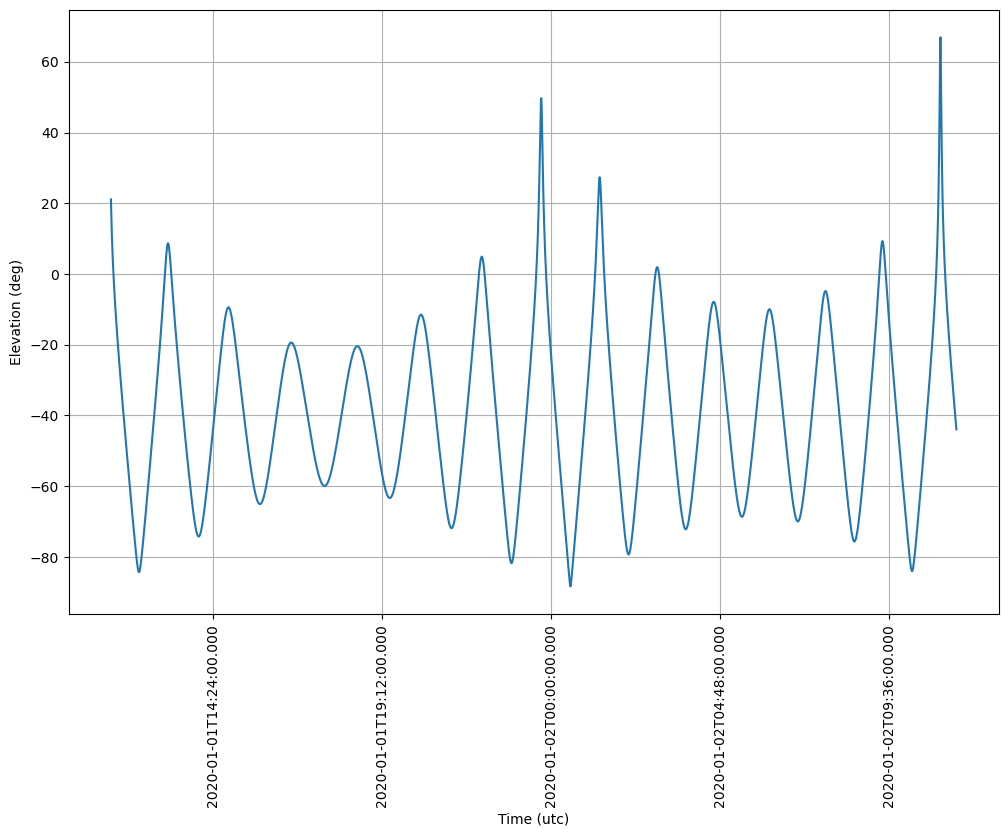

In [22]:
from astropy.visualization import time_support, quantity_support
from matplotlib import pyplot as plt

quantity_support()
time_support(format='isot')

time_list = trajectory.coord_list.obstime
el_list = alt_az_list.alt.deg

fig1, ax1 = plt.subplots(figsize=(12,8), dpi=100)

# Format axes - Change major ticks and turn grid on
ax1.xaxis.set_major_locator(AutoLocator())
ax1.yaxis.set_major_locator(AutoLocator())

ax1.grid(True)

# Set axis labels
ax1.set_ylabel("Elevation (deg)")

# Rotate x axis labels
ax1.tick_params(axis="x", labelrotation=90)

# plot the data and show the plot
ax1.plot(time_list, el_list)

plt.show()

As we can see there are eight occasions where the elevation is higher than zero, but many are actually very low in
elevation. What we want to do is to compute the exact times when the elevation is equal to 5 degrees. Fortunately the
`DiscreteTimeEvents` class does exactly that. We specify a time list, a value list and a threshold. We also specify
whether the event starts or finishes when the value turns from negative (below threshold) to positive
(above threshold).

Then it is easy to query the start and end intervals (in our case communication start and end times) and even
maximum elevation times.

In [23]:
from satmad.utils.discrete_time_events import DiscreteTimeEvents

# Find intervals in data
events = DiscreteTimeEvents(time_list, el_list, 5, neg_to_pos_is_start=True)

print("Start-End Intervals:")
print(events.start_end_intervals)

print("Max Elevation Times:")
print(events.max_min_table)

Start-End Intervals:
[ 2020-01-01T11:30:00.000  2020-01-01T11:32:55.899 ]
[ 2020-01-01T13:04:04.931  2020-01-01T13:10:27.858 ]
[ 2020-01-01T23:35:44.075  2020-01-01T23:49:47.435 ]
[ 2020-01-02T01:16:05.942  2020-01-02T01:28:40.300 ]
[ 2020-01-02T09:20:46.617  2020-01-02T09:27:29.114 ]
[ 2020-01-02T10:56:46.717  2020-01-02T11:09:26.405 ]

Max Elevation Times:
          time          type       value       
----------------------- ---- ------------------
2020-01-01T13:07:12.678  max   8.68022314369674
2020-01-01T23:42:50.184  max   49.8420674228583
2020-01-02T01:22:24.271  max 27.363334067562487
2020-01-02T09:24:04.450  max  9.293958297295152
2020-01-02T11:02:48.296  max  67.57572589797127


The results can be compared to those from GMAT - they are within one millisecond of each other! In reality there are
very minor modelling differences between GMAT and SatMAD such as the choice of ellipsoid or the exact parameters
that are used in the coordinate transformations, which cause such small discrepancies. The computations under the hood
are so complicated that it is extremely difficult to get the results of two libraries to match exactly.

GMAT results:
```
Start Time (UTC)            Stop Time (UTC)               Duration (s)
01 Jan 2020 11:30:00.000    01 Jan 2020 11:32:55.899      175.89892364
01 Jan 2020 13:04:04.931    01 Jan 2020 13:10:27.858      382.92678287
01 Jan 2020 23:35:44.074    01 Jan 2020 23:49:47.435      843.36066647
02 Jan 2020 01:16:05.942    02 Jan 2020 01:28:40.301      754.35891092
02 Jan 2020 09:20:46.618    02 Jan 2020 09:27:29.115      402.49714261
02 Jan 2020 10:56:46.717    02 Jan 2020 11:09:26.405      759.68812035
```

You can change the parameters like propagation accuracy or output stepsize and see how they change the results.